# The Variational Quantum Thermalizer (VQT)

Based on [Quantum Hamiltonian-Based Models and the Variational Quantum Thermalizer Algorithm](https://arxiv.org/abs/1910.02071) by **Jacob Marks** & Guillaume Verdon et al. All code in this repo was written exclusively by Jacob Marks.

In this repo, I have written - for illustrative purposes only - a simple, standalone version of the Variational Quantum Thermalizer engine **from scratch** in Python (AKA not using [Cirq](https://quantumai.google/cirq), [Tensorflow](https://www.tensorflow.org/), or [PennyLane](https://github.com/PennyLaneAI/pennylane-sf)). For a complete tutorial on how the VQT works, c.f. [this](https://pennylane.ai/qml/demos/tutorial_vqt.html) by Jack Ceroni for [Xanadu](https://xanadu.ai/).

## Problem Statement

The general problem we are interested can be stated as follows: suppose that we have a Hamiltonian $\hat{H}$ describing the dynamics of a quantum system, and we want to use a quantum computer to generate an approximation to the thermal state (ensemble) for this system at some temperature $T$.

Symbolically, we denote the ensemble at temperature $T$ as $\hat{\sigma}_{\beta}$, where $\beta = \frac{1}{T}$ is the inverse temperature. The ensemble is defined according to

$$\hat{\sigma}_{\beta} = \frac{1}{\mathcal{Z}_{\beta}}e^{-\beta \hat{H}}$$

where $\mathcal{Z}_{\beta} = Tr\big(e^{-\beta \hat{H}}\big)$ is the partition function for the system.

Our task is to use a quantum processer and a classical processor together to **learn** an approximation, $\hat{\rho}_{\theta \phi}$ to $\hat{\sigma}_{\beta}$. Here, $\{\theta, \phi \}$ represent two sets of variable parameters we are optimizing over.

### Loss Function

Physically, the thermal state is the state that minimizes the [Free energy](https://en.wikipedia.org/wiki/Thermodynamic_free_energy). This fact allows us to use the Free energy of our trial state $\hat{\rho}_{\theta \phi}$ as a loss function:

$$ \mathcal{L}_{VQT}(\theta, \phi) =  \beta \, Tr\big(\hat{\rho}_{\theta \phi} \hat{H} \big) - S(\hat{\rho}_{\theta \phi}) $$

Here, $S(\hat{\rho}_{\theta \phi})$ is the entropy of our trial state.

### General Ansatz Structure

We take our ansatz to have the general form

$$\hat{\rho}_{\theta \phi} = \hat{U}(\phi) \hat{\rho}_{\theta} \hat{U}^{\dagger}(\phi)$$

where $\hat{U}(\phi)$ is a unitary operation that depends on the vector of parameters $\phi$, and $\hat{\rho}_{\theta}$ is our latent state, which depends on the vector of parameters $\theta$. In the most general case, the latent state takes the form:

$$ \hat{\rho}_{\theta} = \sum_{x \in \Omega} p_{\theta}(x) |x\rangle \langle x |$$

where $p_{\theta}(x)$ is a probability distribution ($\sum_{x \in \Omega} p_{\theta}(x) = 1$) and $x \in \Omega$ is a basis set spanning the Hilbert space.

With this ansatz, we can see that the entropy of the trial state reduces to the entropy of the latent state - the von Neumann entropy.

$$S(\hat{\rho}_{\theta \phi}) = S(\hat{\rho}_{\theta}) = -\sum_{x \in \Omega} p_{\theta}(x) \log p_{\theta}(x)$$

### Interpretation

This ansatz structure makes the problem suitable for a quantum processor, in concert with a classical processor. The unitary $\hat{U}(\phi)$ can be represented by a sequence of quantum gates which act on one or two qubits, controlled by variational parameters $\phi$. The latent state $\hat{\rho}_{\theta}$ is represented by a sequence of classical probabilities $p_{\theta}(x)$, controlled by variational parameters $\theta$. With this choice of ansatz, we have classical and quantum variational parameters, and we must simultaneously optimize over both.

We also note that the second term in the loss function can be computed from the classical probabilities alone, on a classical computer.

## Implementation

The files in this folder provide one particular implementation, from scratch, of the VQT engine, as well as the rest of the code needed to perform an example simulation. Here we briefly describe the contents of each file.

### [gateset.py](./gateset.py)

In this implementation, all gates are instances of the <code>Gate</code> class. Each gate object is defined to act on a set of qubits. While some gates, like <code>IdentityGate</code>, are applied with a *fixed* action, other gates depend on input parameters like rotation angles.

#### Gate Methods

<code>Gate.op_mat</code> returns the matrix representation of the operator for given input parameters.

<code>Gate.evaluate_at</code> generates an effective operator for a given set of input parameters, with optional noise generated from a uniform distribution.

<code>Gate.get_differential_gates</code> is used for computing the derivative of a given gate at a particular input $t$ in terms of linear combinations of gates with inputs shifted by offsets. The method returns the requisite shifted gates and their linear coefficients. This is known as the [parameter-shift method](https://arxiv.org/pdf/1905.13311.pdf), and allows us to compute gradients for these parameters without needing to use a finite difference method.

#### One Qubit Gates

All unitary gates in our gate set act on one or two qubits. These gates are all built out of [Pauli matrices](https://en.wikipedia.org/wiki/Pauli_matrices) (including the identity), the [Hadamard gate](https://www.quantum-inspire.com/kbase/hadamard/) - and the two-qubit controlled-not or [CNOT gate](https://en.wikipedia.org/wiki/Controlled_NOT_gate). Explicitly, the Pauli matrices are:

$$ X = \begin{pmatrix}0 & 1 \\ 1 & 0 \end{pmatrix}, \quad \quad Y = \begin{pmatrix}0 & -i \\ i & 0 \end{pmatrix}, \quad \quad Z = \begin{pmatrix}1 & 0 \\ 0 & -1 \end{pmatrix}$$

From these Pauli matrices, we can construct controllable single qubit gates known as rotation gates, which are symbolically represented as:

$$ R_X(t) = e^{-\frac{i}{2} t \, X}, \quad \quad  R_Y(t) = e^{-\frac{i}{2} t\, Y}, \quad \quad R_Z(t) = e^{-\frac{i}{2} t \, Z},$$

where $t$ parameterizes rotation angle. In this implementation, these are respectively represented by <code>RxGate</code>, <code>RyGate</code>, and <code>RzGate</code>, all of which are instances of the subclass <code>RotAxisGate</code>. These three single qubit rotations can be collected into a composite gate <code>SingleQubitRotationGate</code>, which takes three rotation parameters, $t = (t_x, t_y, t_z)$.

#### Two Qubit Gates

We parametrize our controllable two qubit gates similarly to our single qubit gates. Instead of matrix exponentials of individual Pauli matrices, we exponentiate tensor products of Pauli matrices. $X_1 \otimes Y_2$, for instance, means that a Pauli $X$ acts on qubit $1$ and a Pauli $Y$ acts on qubit $2$. In what follows, we omit qubit subscripts and assume that the qubits on which the operators act are implied.

To make the analogy explicit, our two qubit gates, which are known as Ising coupling gates, are denoted in a similar form to the single qubit rotations:

$$ R_{XX}(t) = e^{-\frac{i}{2} t \, X \otimes X}, \quad \quad  R_{YY}(t) = e^{-\frac{i}{2} t\, Y \otimes Y}, \quad \quad R_{ZZ}(t) = e^{-\frac{i}{2} t \, Z \otimes Z}.$$

These gates are represented in the code as <code>RxxGate</code>, <code>RyyGate</code>, and <code>RzzGate</code>, all of which are also instances of the subclass <code>RotAxisGate</code>. As with <code>SingleQubitRotationGate</code>, we can collect these coupling gates into <code>IsingCouplingGate</code> which takes three rotation parameters, $t = (t_{xx}, t_{yy}, t_{zz})$.

### [unitary.py](./unitary.py)

Together with [latent.py](https://arxiv.org/pdf/1910.02071.pdf), this file provides the primitives used to generate quantum circuit objects in [circuit.py](https://arxiv.org/pdf/1910.02071.pdf). The file defines two classes: <code>GateLayer</code>, and <code>CircuitUnitary</code>.

#### GateLayer

A <code>GateLayer</code> is defined on a sequence of gates (<code>Gate</code> objects) acting on a set of qubits (referenced by integer indices). A <code>GateLayer</code> object can consist of any number of one qubit and two qubit gates, so long as each qubit is only acted on by at most one gate - hence the term *layer*.

In this rudimentary implementation, two qubit gates are assumed to act only on neighboring qubits. This is tantamount to assuming that our qubits lie along a line, or an open boundary chain.

<code>GateLayer.evaluate_at</code> naturally extends <code>Gate.evaluate_at</code> via the tensor product operation.

<code>GateLayer.get_differential_layers</code> naturally extends <code>Gate.get_differential_gates</code> via the product rule.

From this primitive, we can define single qubit layers, parameterized by single qubit rotations for each qubit. Additionally, we can define two qubit layers, parameterized by Ising coupling gates on consecutive pairs of qubits. In successive two qubit layers we stagger pairings.

#### CircuitUnitary

The unitary component of our ansatz, $U(\phi)$, is represented by the <code>CircuitUnitary</code> class. A <code>CircuitUnitary</code> object takes as input an array of layers. Our ansatz below assumes alternating layers of one qubit and two qubit gates ($n_{layer} = 4$ corresponds to two layers of one qubit gates, alternating with two qubit gates.

<code>CircuitUnitary.get_layer_unitary</code> constructs the unitary operation (acting on all qubits in the system) for each layer for particular parameters, in the presence or absence of noise.

<code>CircuitUnitary.evaluate_at</code> and <code>CircuitUnitary.get_differential_unitaries</code> naturally extend these concepts from the <code>GateLayer</code> level.

### [latent.py](./latent.py)

 The latent state, $\rho_{\theta}$, is represented by a <code>LatentDistribution</code> object. For simplicity, we define two distinct forms for the latent distribution.

First, <code>FullLatentDistribution</code> corresponds to the most general latent state possible:

$$ \hat{\rho}_{\theta} = \sum_{x \in \Omega} p_{\theta}(x) |x\rangle \langle x |,$$

which has $2^N$ parameters, where $N$ is the number of qubits in the system. Even though the entropy of the ansatz can be computed directly from these classical probabilities (with the classical processor alone), this scaling of the number of variational parameters with system size quickly makes the problem intractable. For small system sizes, however, we can get away with this. 

Second, <code>FactorizedLatentDistribution</code> corresponds to a latent state of the form:

$$ \hat{\rho}_{\theta} =  \bigotimes_{j = 1}^{N} \hat{\rho}_j(\theta_j), $$

which introduces one new variable per qubit. The von Neumann entropy in this case can be computed as:

$$ S(\hat{\rho}_{\theta}) = \sum_{j=1}^N S\big(\hat{\rho}_j \, (\theta_j) \big)$$

The scaling with system size for the factorized latent state is obviously much better, but in exchange we have sacrificed generality and expressive power.

One possibility which allows for both expressivity and relative ease of computation (even for large systems) is to employ an [energy based model](https://en.wikipedia.org/wiki/Energy_based_model) to learn an approximation to the latent distribution. However, a complete implementation thereof is beyond the scope of this illustration.

### [circuit.py](./circuit.py)

The <code>Circuit</code> class combines both the circuit unitary and the latent state in one unified framework. A <code>Circuit</code> object defines an ansatz for the entire mixed/thermal state. In this framework, the latent state parameters and gate parameters are essentially concatenated into a single array, allowing for gradient descent to be performed.

### [optimization_engine.py](./optimization_engine.py)

In our variational optimization, we use an [Adam optimizer](https://arxiv.org/abs/1412.6980), wrapped in an <code>OptimizationEngine</code> object.

### [vqt.py](./vqt.py)

Finally, everything culminates in the VQT engine. A <code>VQTEngine</code> object contains the necessary ingredients for posing the approximation problem - the Hamiltonian $\hat{H}$ of the system to be approximated, and the (inverse) temperature $\beta$ defining the thermal state - as well as the conditions governing the variational optimization itself - the cirtcuit ansatz, variance in noise to be added to simulation, and the number of measurements we take to arrive at each expectation value.

The <code>VQTEngine.run</code> method takes in a particular optimization engine (defaulting to ADAM), and iteratively updates model parameters until either a minimum in the loss function is reached, or the maximum number of iterations is reached.

## Demonstration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from circuit import *
from hamiltonian import *
from vqt import *

In [2]:
np.random.seed(127)

### Model System

We consider a simple one-dimensional [Heisenberg model](https://en.wikipedia.org/wiki/Quantum_Heisenberg_model#:~:text=The%20quantum%20Heisenberg%20model%2C%20developed,systems%20are%20treated%20quantum%20mechanically.) with transverse and longtitudinal magnetic fields:

$$ \hat{H} = J \sum_{\langle ij \rangle} \hat{S}_i \cdot \hat{S}_j + \sum_j \big( h^x S^x_j + h^z S^z_j \big)   $$

Here, $\hat{S}^{\mu}_j$ denotes the $\mu$ component of the spin on site $j$, $h$ represents the magnetic field, $j$ enumerates all sites on a one-dimensional lattice, and $\langle ij \rangle$ indexes all pairs of neighboring sites. The Hamiltonian for this model is defined in the function <code>gen_heisenberg1d_hamiltonian</code> in [hamiltonian.py](./hamiltonian.py).

As this notebook is for illustrative purposes only, we consider a two-site chain, and we take the particular Hamiltonian with parameters $J = -1$, $h^x = 0.3$, and $h^z = 0.1$.

In [3]:
nqubits = 2
J = -1.0
hx = 0.3
hz = 0.1

In [4]:
H = gen_heisenberg1d_hamiltonian(nqubits, J = J, hx = hx, hz = hz)

We will attempt to construct an approximation to the thermal state of this system at an intermediate temperature, $\beta = 2.5$.

In [5]:
beta = 2.5

### Success Metrics

The goal of the Variational Quantum Thermalizer is to produce an ensemble that approximates a thermal state. We can measure the success of the approximation by quantitatively comparing the approximation and the target state. We do this in two ways. Both methods are defined in [utils.py](./utils.py).

The [fidelity](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states) measures the closeness of two quantum states. For two mixes states, $\hat{\rho}$ and $\hat{\sigma}$, the fidelity is defined as:

$$ F(\hat{\rho}, \hat{\sigma}) = \Big[ Tr \sqrt{\sqrt{\hat{\rho}}\, \, \hat{\sigma} \sqrt{\hat{\rho}} } \Big]^2  $$

A value of $F = 0$ means the two states are orthogonal, and a value of $F = 1$ implies the two states are identical. The closer to one, the better the approximation.

The [trace distance](https://en.wikipedia.org/wiki/Trace_distance) on the other hand measures the distance between two states. For two mixes states, $\hat{\rho}$ and $\hat{\sigma}$, the trace is defined as:

$$ T(\hat{\rho}, \hat{\sigma}) = \frac{1}{2} Tr \big[\sqrt{((\hat{\rho} - \hat{\sigma})^{\dagger}(\hat{\rho} - \hat{\sigma})} \big] $$

The trace distance is a metric, and comes with all properties associated with a metric. In particular, $0 \leq T(\hat{\rho}, \hat{\sigma}) \leq 1$, with $T(\hat{\rho}, \hat{\sigma}) = 0$ if and only if $\hat{\rho} = \hat{\sigma}$.

### Setting up the simulation

We will assume a general latent space distribution (<code>factorized = False</code>)

We will perform the VQT algorithm three different times, with different numbers of layers in the circuit, $n_{layer} \in \{2, 4, 8\}$. We will also refer to the number of layers as *circuit depth*.

Finally, we will assume our parameter settings are **noiseless**.

For reference, we can explicitly compute (in this example) the exact thermal state:

In [6]:
rho_thermal = get_thermal_state(H, beta)

Additionally, we can compute the free energy of this thermal state, which we know by construction minimizes our loss function. We will denote this quantity by $\mathcal{L}^*$.

In [14]:
loss_star = get_free_energy(rho_thermal, beta, H)
print("L* = {}".format(loss_star))

L* = -4.3027445766374015


### Simulation

In [18]:
circuit_depths = [2, 4, 8]

In [19]:
vqts = []

In [20]:
for i, cd in enumerate(circuit_depths):
    circ = generate_circuit(nqubits, cd)
    vqts.append(VQTEngine(circ, H, beta))
    print("-"*30)
    print("n_layer = {}".format(cd))
    print("Starting variational optimization")
    vqts[i].run(verbose = False)

------------------------------
n_layer = 2
Starting variational optimization
Final loss: -3.863839862003636
------------------------------
n_layer = 4
Starting variational optimization
Final loss: -4.230711399699506
------------------------------
n_layer = 8
Starting variational optimization
Final loss: -4.298580669488182


The more layers, the better our approximation!

We can also plot the loss for each simulation over the course of the optimization routine:

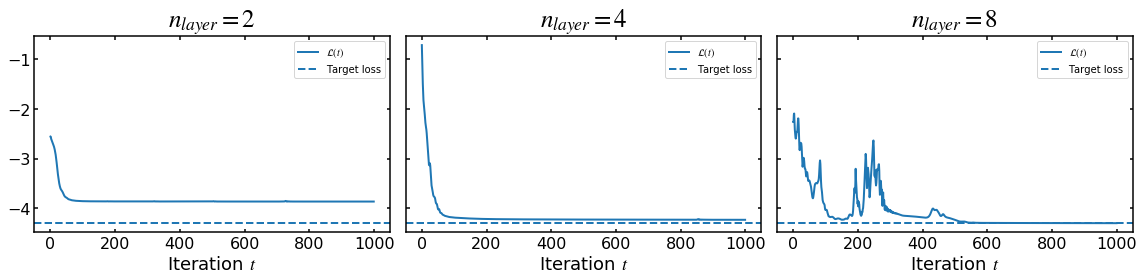

In [31]:
fig, axs = plt.subplots(1, 3, figsize = (16, 4), sharey = True)
for i, ax in enumerate(axs):
    ax.set_title(r'$n_{layer} =$' + r'${}$'.format(circuit_depths[i]), fontsize = 25)
    vqts[i].plot_loss(ax)
    plt.tight_layout()

We see that the $n_{layer} = 8$ trial ran into more local minima, as it has far more variational parameters. But in the end, it was able to achieve the most accurate approximation.

Finally, we can compute the fidelity and trace distance between these approximations and our target thermal state:

In [37]:
fids, tds = [], []
for i, cd in enumerate(circuit_depths):
    rho_approx = vqts[i].get_circuit_rho()
    fids.append(get_fidelity(rho_thermal, rho_approx))
    tds.append(get_trace_distance(rho_thermal, rho_approx))  
fids, tds = np.array(fids), np.array(tds)

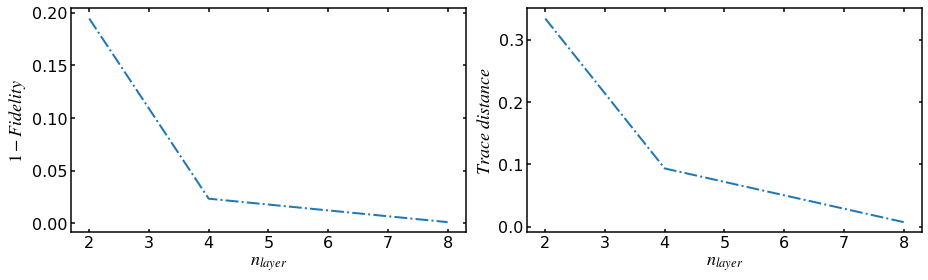

In [62]:
fig, axs = plt.subplots(1, 2, figsize = (13, 4))

axs[0].set_ylabel(r'$1 - Fidelity$')
axs[0].plot(circuit_depths, 1 - fids, ls = '-.')
axs[1].set_ylabel(r'$Trace \, \, distance$')
axs[1].plot(circuit_depths, tds, ls = '-.')

for ax in axs:
    ax.set_xlabel(r'$n_{layer}$')
plt.tight_layout()

## Conclusion

I want to reiterate that this illustration is simple by construction. The point here is not to highlight the technical nuances that arise during variational optimization, barren plateaus in quantum gradients, or to showcase the full generality of this approach. Rather, this is meant to be a modular, dependency-free implementation of the VQT that illustrates its main ingredients. 

Feel free to reach out to me at jamarks13@gmail.com with any questions!